# Twitter Political Bias Classificator

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import pandas as pd
import numpy as np


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

##  Data

### Users

In [2]:
accounts = pd.read_csv('../../data/accounts.csv', delimiter=';')
accounts.head()

,username,spectrum
0,AdrillesRJorge,conservative
1,alamoju,progressist
2,amykaellasc,conservative
3,anapaularenault,progressist
4,andrefran,progressist


In [3]:
accounts.shape

(82, 2)

In [4]:
unique, counts = np.unique(accounts['spectrum'], return_counts=True)
print(unique, counts)

['conservative' 'neutral' 'progressist'] [32  7 43]


<BarContainer object of 3 artists>

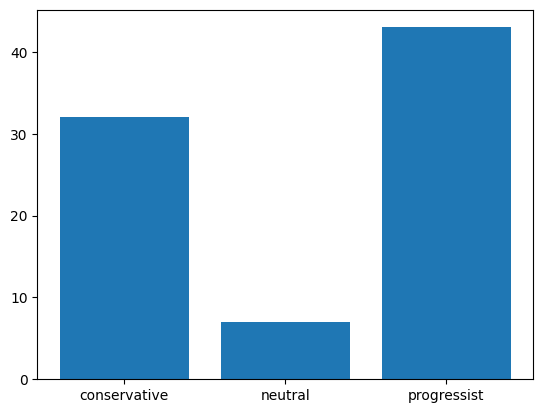

In [5]:
fig, ax = plt.subplots(1 ,1)
ax.bar(unique, counts)

### Tweets

In [6]:
tweets = pd.read_csv('../../data/tweets.csv', delimiter=';')
tweets.head()

,id,actor_id,actor_username,withheld,created_at,harvested_at,conversation_id,lang,like_count,retweet_count,reply_count,quote_count,text,spectrum
0,1603142693970145280,3060235071,AdrillesRJorge,True,2022-12-14 21:39:37+00:00,2022-12-17 00:06:45+00:00,1603142693970145280,pt,33,4,2,0,Ninguém vive de amor próprio . Conversa fiada ...,conservative
1,1599530988924649472,3060235071,AdrillesRJorge,True,2022-12-04 22:28:00+00:00,2022-12-17 00:06:45+00:00,1599530988924649472,pt,129,19,9,1,O ouro de tolo da ostentação humana https://t....,conservative
2,1597975760853405697,3060235071,AdrillesRJorge,True,2022-11-30 15:28:04+00:00,2022-12-17 00:06:45+00:00,1597975760853405697,pt,0,11979,0,0,"RT @o_antagonista: ""Não estou tendo o devido p...",conservative
3,1597970726434504704,3060235071,AdrillesRJorge,True,2022-11-30 15:08:04+00:00,2022-12-17 00:06:45+00:00,1597970726434504704,pt,0,13830,0,0,RT @Rconstantino: Que país é esse em que trafi...,conservative
4,1597880306568032256,3060235071,AdrillesRJorge,True,2022-11-30 09:08:46+00:00,2022-12-17 00:06:45+00:00,1597880306568032256,pt,0,4889,0,0,RT @JovemPanNews: #PróseContras | Piotto: “Voc...,conservative


In [7]:
unique, counts = np.unique(tweets['spectrum'], return_counts=True)
print(unique, counts)

['conservative' 'neutral' 'progressist'] [ 95630  22233 125761]


<BarContainer object of 3 artists>

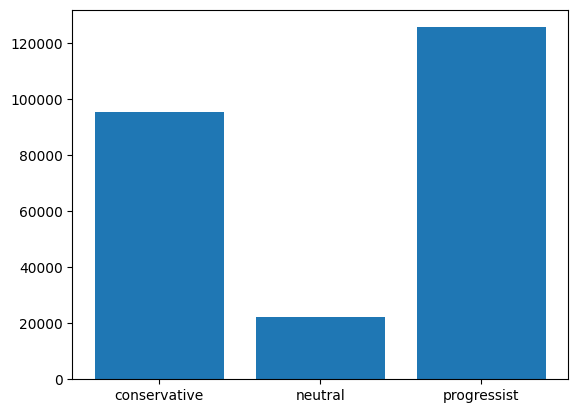

In [8]:
fig, ax = plt.subplots(1 ,1)
ax.bar(unique, counts)

In [9]:
tweets = tweets.sample(1000).reset_index(drop=True).copy()

## Preprocessing

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(tweets['spectrum'])

tweets['spectrum'] = le.transform(tweets['spectrum'])

In [11]:
from nltk.tokenize import TweetTokenizer

from preprocessing import preprocessing

In [12]:
tt_tknzr = TweetTokenizer(preserve_case=True, reduce_len=True, strip_handles=True)

In [13]:
tweets['text_normalized'] = tweets['text'].apply(lambda x: preprocessing(x, tt_tknzr))

Removing unused columns

In [14]:
tweets.drop(tweets.columns[:-2], axis=1, inplace=True)

Removing duplicates

In [15]:
old_len = tweets.shape[0]
tweets.drop_duplicates(inplace=True)
print(f'{old_len - tweets.shape[0]} tweets were dropped.')

35 tweets were dropped.


In [16]:
tweets.head()

,spectrum,text_normalized
0,0,polegar para cima: tom de pele claro lingua lí...
1,0,"Olá , pessoal ! Estou disponibilizando o meu w..."
2,0,🫡
3,0,Ser poderoso é como ser uma dama se você prec...
4,0,Relatório do Deutsche Bank cita trabalho ESPET...


In [17]:
from sklearn.model_selection import train_test_split

In [18]:
RANDOM_SEED = 777

df_train, df_test = train_test_split(tweets, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [20]:
import tensorflow as tf
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [30]:
import transformers
from transformers import TFBertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelForPreTraining, AutoModel

In [22]:
# PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-large-portuguese-cased'
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

# bert_model = TFBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, from_pt=True)
bert_model = TFBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_tknzr = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=False)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-12-29 10:31:44.580530: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-29 10:31:44.580954: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some layers from the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly

In [31]:
from typing import List, Tuple
from tensorflow.keras.utils import Sequence

BATCH_SIZE = 32
MAX_LEN = 280

class DataGenerator(Sequence):

    def __init__(self, x_in: np.array, y_in: np.array, tokenizer: transformers.AutoTokenizer, max_len: int, batch_size: int, shuffle: bool=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.x = x_in
        self.y = y_in
        self.tokenizer = tokenizer
        self.datalen = len(y_in)
        self.indexes = np.arange(self.datalen)
        self.max_len = max_len
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index: int) -> Tuple[List[np.array], np.array]:
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        x_batch = self.x[batch_indexes]
        y_batch = self.y[batch_indexes]

        input_ids = []
        attention_masks = []
        
        for text in x_batch:
            encoded = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=self.max_len,
                padding='max_length',
                return_attention_mask=True,
            )

            input_ids.append(encoded['input_ids'])
            attention_masks.append(encoded['attention_mask'])

        return [np.array(input_ids, dtype=np.int64), np.array(attention_masks, dtype=np.int64)], y_batch

    def __len__(self):
        return self.datalen // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(self.datalen)
        if self.shuffle:
            np.random.shuffle(self.indexes)

train_gen = DataGenerator(df_train['text_normalized'].to_numpy(), df_train['spectrum'].to_numpy(), bert_tknzr, MAX_LEN, BATCH_SIZE)
test_gen = DataGenerator(df_test['text_normalized'].to_numpy(), df_test['spectrum'].to_numpy(), bert_tknzr, MAX_LEN, BATCH_SIZE, shuffle=False)
val_gen = DataGenerator(df_val['text_normalized'].to_numpy(), df_val['spectrum'].to_numpy(), bert_tknzr, MAX_LEN, BATCH_SIZE)

In [24]:
import tensorflow as tf

def create_model(bert_model: TFBertModel) -> TFBertModel:
    input_ids = tf.keras.Input(shape=(MAX_LEN,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(MAX_LEN,), dtype='int32')

    output = bert_model([input_ids, attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation='softmax')(output)

    model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [25]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 280)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 280)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108923136   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 280,                                           

In [26]:
N_EPOCHS = 10

In [27]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4),
    tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoints/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

In [28]:
history = model.fit(
    train_gen, 
    epochs=N_EPOCHS, 
    validation_data=val_gen, 
    verbose=1, 
    shuffle=True, 
    callbacks=callbacks
)

Epoch 1/10


2022-12-29 10:31:49.305551: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-29 10:31:55.821846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 2/27 [=>............................] - ETA: 13:29 - loss: 0.3392 - accuracy: 0.3906

KeyboardInterrupt: 

In [ ]:
from matplotlib.ticker import MaxNLocator

In [ ]:
n = len(history.history['accuracy'])
accuracy = np.zeros(n + 1)
val_accuracy = np.zeros(n + 1)

for i in range(n):
    accuracy[i + 1] = history.history['accuracy'][i]
    val_accuracy[i + 1] = history.history['val_accuracy'][i]

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

epochs = [(i + 1) for i in range(n + 1)]

ax.plot(
    epochs,
    accuracy,
)

ax.plot(
    epochs, 
    val_accuracy
)

ax.scatter(epochs, accuracy)
ax.scatter(epochs, val_accuracy)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))


labels = ['Accuracy', 'Validation Accuracy']

colors = ['#1f77b4', '#ff7f0e']
for i, value in enumerate([accuracy[-1], val_accuracy[-1]]): 
    ax.text(
        n + 1,
        value - 0.01,
        labels[i],
        c=colors[i],
        horizontalalignment='left',
        verticalalignment='top',
        size=14
    )
    
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Data split')

fig.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
predictions = model.predict(test_gen)

y_pred = [le.inverse_transform(np.argmax(pred).reshape(-1,1))[0] for pred in predictions]
cf_matrix = confusion_matrix(le.inverse_transform(df_test['spectrum']), y_pred, normalize='true')


disp = ConfusionMatrixDisplay(cf_matrix, display_labels=set(le.inverse_transform(df_test['spectrum'])))

fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax, xticks_rotation=45)

disp.ax_.set_title('Confusion Matrix')
disp.im_.colorbar.remove()
disp.ax_.set_xlabel('Predicted label')

# plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
accuracy = accuracy_score(
    le.inverse_transform(df_test['spectrum']), y_pred
)
accuracy

In [ ]:
f1 = f1_score(
    le.inverse_transform(df_test['spectrum']), y_pred, 
    labels = list(set(le.inverse_transform(df_test['spectrum']))), 
    average = 'micro'
)
f1

In [ ]:
model.save('./model/doodles.h5', include_optimizer=False)

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='topology.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)